# Machine Learning For Identifying Globular Cluster Candidates

## Contents
+ [1. Imports](#imports)
+ [2. Catalogue File Processing](#cat_proc)
+ [3. Catalogue Matching](#cat_match)
+ [4. Models](#models)
    + [4.1 Random Forest](#models_rf)
    + [4.2 Multi-layer Perceptron](#models_mlp)
+ [5. ](#)
+ [6. ](#)

<a id='imports'></a>
# Imports

In [327]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import astropy.coordinates as coord
import astropy.units as u

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC #???????????????//
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from astropy.table import QTable, join
from astropy.io import ascii
from itertools import permutations, product
from time import time
from pathlib import Path

In [328]:
# select most recent training data
train_file = 'training_data_2704.pk'

with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [329]:
bounds = pickle.load(open('./pickle/bounds.pk','rb'))
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv') #2184 objects long
master_cat = master_cat.drop_duplicates(ignore_index=True)
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']
# note: although we load the entire range of fields to only return a single one, pickle will hold the whole file in memory
# so subsequent field loads (assuming they are consecutive) will not actually re-load the file and will instead
# take it from memory
def load_cat(field):
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            to_load = cat_files[b]
            break
    with open(f'./pickle/{to_load}','rb') as f:
        catalogue = pickle.load(f)
    return catalogue[field] # return only the requested field table


#for the sake of this demo code, we will only load the single catalogue file
#as they are far too large to include them all here
def load_cat(field):
    with open(f'./pickle/cat229.pk','rb') as f:
        catalogue = pickle.load(f)
    if field!=229: return {field:[]} # return an empty dictionary for any other field
    return catalogue[field]

<a id='cat_proc'></a>
# Catalogue File Processing

In [330]:
def read_cat(c: range) -> dict:
    columns = ['RA', 'Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','ia','field']
    CAT = {}
    for a in c:
        print(f'\nReading {a:03d}')
        CAT[a] = ascii.read(f'./catdata/cats/m{a:03d}p.ascd', guess=False, header_start=0, names=columns, format='commented_header')
        print('Converting RA/Dec')
        CAT[a]['RA'] = coord.Angle(CAT[a]['RA'],u.h).deg
        CAT[a]['Dec'] = coord.Angle(CAT[a]['Dec'],u.deg).deg
        print('Centering RA values')
        # correct for fields that cross over the RightAscension = 0 boundary
        CAT[a]['RA'] = [(a+20)%360-20 for a in CAT[a]['RA']]
        print('Saving...')
    return CAT

Any range of catalogue files can be read in and saved. Here we will use field 229 as an example.

In [331]:
CAT229 = read_cat(range(229,230))
with open('./pickle/cat229.pk','wb') as f:
    pickle.dump(CAT229,f)


Reading 229
Converting RA/Dec


KeyboardInterrupt: 

Printed below is the data table for this field:

In [286]:
CAT229[229]

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,ia,field
float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,int32,int32
7.500345833333334,40.60864166666667,1,1914.42,1443.22,13.8,0.001,-9,1901.33,1472.02,12.902,0.001,-9,0,229
7.4668458333333305,40.669066666666666,1,1419.09,265.96,13.809,0.001,-9,1405.77,295.07,13.024,0.001,-9,0,229
7.498791666666666,40.57726666666667,1,1889.88,2057.81,13.828,0.001,-9,1876.98,2086.37,12.976,0.001,-9,0,229
7.502395833333331,40.56137222222222,1,1943.03,2367.7,13.837,0.001,-9,1930.21,2396.21,13.007,0.001,-9,0,229
7.3778958333333335,40.60429722222222,1,93.89,1555.33,14.157,0.001,-9,81.3,1583.81,13.463,0.001,-9,0,229
7.3790916666666675,40.47244722222222,1,108.84,4124.51,14.186,0.001,-9,97.0,4152.19,13.45,0.001,-9,0,229
7.4124333333333325,40.556999999999995,1,604.61,2472.22,14.209,0.001,-9,592.16,2500.49,13.525,0.001,-9,0,229
7.482308333333332,40.50189722222222,1,1642.59,3532.5,14.253,0.001,-9,1630.19,3560.61,13.339,0.001,-9,0,229
7.462433333333333,40.560919444444444,1,1347.88,2385.37,14.34,0.001,-9,1335.21,2413.79,13.663,0.001,-9,0,229


<a id='cat_match'></a>
# Catalog Matching
Run all the function definitions.

In [332]:
# match objects in CAT[n] to the ones in master_cat
# matches every object from CAT[n] so the resulting arrays are len(CAT[n]) long
def match_objs(cat_no: int) -> (np.ndarray, np.ndarray):
    d1 = CAT[cat_no]
    ra_obs, dec_obs = d1['RA'], d1['Dec']
    d2 = master_cat
    ra_qry, dec_qry = d2['RADEG'], d2['DECDEG']

    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, d2d, _ = c1.match_to_catalog_sky(c2)
    return idx,d2d #idx: the index of the object in RBC, d2d: distance to that object from CAT

# find a list of all objects from match_objs that are actually contained within a given field
# as the returned objects of match_objs contains ones from master_cat which are outside of the given field
#   __________
#  |   *     |   *  <-- remove points like this
#  |      *  |
#  |  *    * |
#  |_____*___|
#
def find_objs_in_field(cat_no: int, objs: list) -> list:
    in_field = []
    for o in objs:
        ra = master_cat.loc[o]['RADEG']
        dec = master_cat.loc[o]['DECDEG']
        x0,x1,y0,y1 = bounds[cat_no]
        if ( ra<x0 and ra>x1 and dec>y0 and dec<y1 ):
            in_field.append(master_cat.loc[o])
    return in_field

# find the closest match(es) for each object in the master_list, that is in a given field
# returns a list of 3-tuples of the format (CAT index, master_cat index, nearby obj count)
def find_closest_match(in_field: list, delta: float) -> list:
    ret = []
    
    for obj in in_field:
        idx = obj.name #obj.name is the position/index of the object in master_cat
        delta_filter = d2d_idx_df[d2d_idx_df['idx']==idx]['d2d'] < delta
        obj_delta = d2d_idx_df[d2d_idx_df['idx']==idx][delta_filter] # returns list of objects within delta of the position from master_cat
        
        # filter matches by dg/di values
        closest_obj_idx = -1
        for i in obj_delta.sort_values('d2d').index:
            if CAT[c][i]['di'] > 0.05 or CAT[c][i]['dg'] > 0.05: # filter out sources with uncertain magnitudes
                continue
            elif (obj_delta[obj_delta.index==i]['d2d'] < 0.0005).bool(): #ensure the point is nearby (1.8 arcsec)
                closest_obj_idx = i # if the dg/di is in the right range (and close enough to true position) then use that index
                break
        if closest_obj_idx == -1: # if no matches were found in the above for loop
            continue # skip this object as there are no reasonable matches
        
        out = (closest_obj_idx, idx, len(obj_delta)) # return index of object in CAT[n], index in master_cat, and number of nearby objects(for crowding analysis)
        ret.append(out)
    return ret

### Matching PAndAS catalogue files to master_cat

In [333]:
matches = {}

#cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
#             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

#for the sake of this demo code we use just one of the groups of catalogues
cat_files = ['cat229.pk']

for f in cat_files:
    print(f'\n{f}')
    CAT = pickle.load(open(f'./pickle/{f}','rb'))
    print('Loaded...')
    for c in CAT:
        idx,d2d = match_objs(c)
        objs = set(idx)
        d2d = d2d.degree
        
        d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]
        
        d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])
        
        # get the list of all obj from master_cat which are in the field CAT[c]
        in_field = find_objs_in_field(c,objs)
        delta = 0.005 # the size of the region in which to determine crowding (0.006 deg = 21.6 arcsec)
        matches[c] = find_closest_match(in_field, delta=delta)
        
        
print('Done!')


# remove crowded objects and empty fields
empty_fields = []
for c in range(1,407):
    try:
        if matches[c] == []:
            empty_fields.append(c)
            matches.pop(c,None)
    except: continue

with open('./pickle/matches/matches.pk','wb') as f:
    pickle.dump(matches,f)


cat229.pk
Loaded...
Done!


In [334]:
print(matches)

{229: [(198028, 34, 74), (137396, 39, 17), (131289, 40, 60), (215894, 27, 66), (179619, 41, 80)]}


============================

The code above returns a dictionary where each entry represents a field (in this case field 229). Each entry is a list, composed of 3-tuples of the format:

    (index in PAndAS catalogue, index in master catalogue, number of sources within 18arcsec)
    
Here, we got five matches in the field, corresponding to the following four globular clusters, and one galaxy:

In [66]:
master_cat.loc[[t[1] for t in matches[229]]]

,ID,RADEG,DECDEG,CLASS,DATATABLE
34,MCGC1,6.698708,39.746194,1.0,m31rbcV5
39,2M019,6.879125,40.133750,4.0,m31rbcV5
40,H2,7.013583,40.048692,1.0,m31rbcV5
27,PAndAS-16,6.249667,39.703642,1.0,huxor14_table1
41,PAndAS-18,7.096917,39.918017,1.0,huxor14_table1


# Building Training Dataset

In [335]:
object_matches = pickle.load(open('./pickle/matches/matches.pk','rb'))

In [336]:
def generate_training_data(matches, crowding=300) -> pd.DataFrame:
    cat = load_cat(1)
    
    columns = ['obj_id','class','i','g','di','dg','ra','dec','field','pdidx']
    values = []
    object_ids = []
    
    #TEMP
    crowded_objects = []
    
    
    for field in matches: # iterate through each field ID
        cat = load_cat(field)
        print(f'Working on {field}')
        working_field = matches[field] # take the list of matches e.g. working_field = [(166727, 2642), (159637, 2646)]
        
        for m in working_field: # iterate through each match (a tuple) and grab values from catalogues
            
            if m[2] > crowding: # testing
                crowded_objects.append(m[1:])
                continue
            
            obj_id = master_cat.loc[m[1]].ID
            class_ = master_cat.loc[m[1]].CLASS
            
            if obj_id in object_ids: continue # if we've already added the object then skip
            else: object_ids.append(obj_id)   # else add it to the list of ids
            
            if class_ == 1: class_str = 'gc' # convert class numbers into strings
            elif class_ == 4: class_str = 'galaxy'
            elif class_ == 6: class_str = 'star'
            else: continue # skip non-gc/gal/stars
            
            # collect required data
            row = cat[m[0]]
            ra = row['RA']
            dec = row['Dec']
            g = row['g']
            i = row['i']
            dg = row['dg']
            di = row['di']
            
            values.append([obj_id,class_str,i,g,di,dg,ra,dec,field,m[0]])
    
    training_data_dict = dict(zip(columns,zip(*values))) # zip values and columns together into a dict (columns as keys)
    training_data_df = pd.DataFrame(training_data_dict) # put into pd Dataframe
    return training_data_df, crowded_objects

We execute the above function on our matches:

In [337]:
training_data,crowded_objects = generate_training_data(object_matches)

Working on 229


And gain the following training data set with the required values:

In [338]:
training_data

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx
0,MCGC1,gc,14.693,15.711,0.001,0.001,6.698988,39.746158,229,198028
1,2M019,galaxy,17.761,18.982,0.001,0.001,6.878996,40.133711,229,137396
2,H2,gc,17.725,18.414,0.001,0.001,7.013483,40.048756,229,131289
3,PAndAS-16,gc,16.901,17.605,0.001,0.001,6.249696,39.703656,229,215894
4,PAndAS-18,gc,22.520,23.375,0.026,0.021,7.097300,39.917811,229,179619


Of course, every field was considered for the full project and so we load in the full training set later.

### Adding 2MASS Data To Training
Here we add the tables from 2MASS (again, only using 229 as an example)

In [339]:
# match 2mass to objects in training_data
# returns a list of indexes in 2MASS which correspond to each item in the training_data
def match_2mass_train(field, tbl_2mass):
    d1 = tbl_2mass
    ra_obs, dec_obs = d1['ra'], d1['dec']
    d2 = training_data[training_data['field']==field]
    ra_qry, dec_qry = d2['ra'], d2['dec']

    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, d2d, _ = c2.match_to_catalog_sky(c1)
    d2d = d2d.degree
    in_range = [d2d[i]<=0.001 for i in range(len(idx))]
    return idx, in_range #idx: the index of the object in 2MASS, d2d: distance to that object

def get_filtered_2mass(field:int):
    ABC = [''.join(p) for p in product('ABC','ABC','ABC')] # all permutations of A,B,C quality results
    filtered_table = ascii.read(f'./catdata/2mass/{field}.tbl', format='ipac').to_pandas()
    filtered_table = filtered_table[filtered_table['ph_qual'].isin(ABC)].reset_index()
    return filtered_table

In [340]:
# iterate fields and add 2MASS data to the training set
for f in [229]:
    cat = load_cat(f)
    _2MASS_table = get_filtered_2mass(f)
    idx,in_range = match_2mass_train(f,_2MASS_table)
    training_data_indexes = training_data[training_data['field']==f].index
    for i in range(len(idx)):
        training_data.loc[training_data_indexes[i],'j'] = _2MASS_table.loc[idx[i],'j_m']
        training_data.loc[training_data_indexes[i],'h'] = _2MASS_table.loc[idx[i],'h_m']
        training_data.loc[training_data_indexes[i],'k'] = _2MASS_table.loc[idx[i],'k_m']
        training_data.loc[training_data_indexes[i],'ph_qual'] = _2MASS_table.loc[idx[i],'ph_qual']
        training_data.loc[training_data_indexes[i],'2mass_acc'] = in_range[i]

Now we have 2MASS data added to the training data set as shown below:

In [341]:
training_data

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,j,h,k,ph_qual,2mass_acc
0,MCGC1,gc,14.693,15.711,0.001,0.001,6.698988,39.746158,229,198028,14.727,14.166,14.072,AAA,True
1,2M019,galaxy,17.761,18.982,0.001,0.001,6.878996,40.133711,229,137396,15.522,14.946,14.501,AAB,True
2,H2,gc,17.725,18.414,0.001,0.001,7.013483,40.048756,229,131289,16.191,15.632,15.295,BCB,True
3,PAndAS-16,gc,16.901,17.605,0.001,0.001,6.249696,39.703656,229,215894,15.058,14.482,14.531,AAB,True
4,PAndAS-18,gc,22.520,23.375,0.026,0.021,7.097300,39.917811,229,179619,16.313,16.047,15.676,BCC,False


<a id='models'></a>
# Models

Here we will load in the true full training data set

In [342]:
# select most recent training data
train_file = 'training_data_2704.pk' 

with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [343]:
training_data

,obj_id,class,i,g,g-i,di,dg,ra,dec,field,pdidx,rbcidx,nearby,j,h,k,ph_qual,2mass_acc,i-j
0,HM33-A,gc,22.424000,22.940001,0.516001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,13.028,12.881,12.805,AAA,False,9.396000
1,C30,galaxy,18.049000,19.500999,1.452000,0.001,0.002,12.105896,29.267633,11,118854,2431,24,15.869,15.216,14.756,AAB,True,2.180000
2,LAMOST-C22,galaxy,17.628000,19.153000,1.525000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,15.251,14.503,13.918,AAA,True,2.377000
3,HM33-B,gc,19.538000,20.386000,0.848000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,16.429,15.589,15.154,BBC,False,3.109000
4,LAMOST-C18,galaxy,17.177999,18.388000,1.210001,0.001,0.001,23.842129,29.552473,14,122860,2644,12,14.838,14.277,13.847,AAA,True,2.339999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,PA-N185,gc,20.188000,21.688999,1.500999,0.005,0.007,9.578100,48.367985,398,256376,306,106,11.881,11.436,11.314,AAA,False,8.307000
1330,FJJ-V,gc,17.434999,18.451000,1.016001,0.001,0.001,9.806167,48.384743,398,168423,372,156,13.321,12.966,12.889,AAA,False,4.113999
1331,FJJ-VII,gc,19.523001,20.520000,0.997000,0.003,0.004,9.826713,48.384266,398,168594,377,163,14.687,14.317,14.254,AAA,False,4.836001
1332,PA-N147-3,gc,19.910000,20.820999,0.910999,0.004,0.004,8.542029,49.044243,402,101369,91,36,14.378,13.857,13.694,AAA,False,5.532000


<a id='models_rf'></a>
## Random Forest Models
Functions defining the random forest model, taking a training set and parameters and returning a classifier and, if chosen, train and test results from model training.  
Another functions, rf_pred, also takes a field as a parameter and makes predictions on that field.

In [344]:
# generate the classifier and return (with optional returning of train and test values)
def ranfor(df,train_size=0.8,n_estimators=50,criterion='gini',features=['i','g','g-i'], max_depth=None, 
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, max_features=2 ,stats=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    ran_for_class = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                    criterion=criterion, max_leaf_nodes=max_leaf_nodes, max_features=max_features,
                                    min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_jobs=-1
                                   ).fit(X_train,y_train)
    
    
    #acc = ran_for_class.score(X_test,y_test)
    
    #true = y_test.to_numpy()
    if stats:
        train_pred = ran_for_class.predict(X_train)
        test_pred = ran_for_class.predict(X_test)
        return ran_for_class, test_pred, y_test, train_pred, y_train
    else: return ran_for_class

In [345]:
# returns predictions for a given field, allowing a crowding parameter to filter training values
def rf_pred(field:int,train:pd.DataFrame,crowding=300,n_estimators=50,max_depth=None,max_leaf_nodes=None,min_samples_leaf=1,features=['i','g','g-i']):
    training_data_ = train[train['nearby'] <= crowding]
    cat = load_cat(field)
    
    # drop rows with high delta g/i values
    cat_d = cat[cat['dg']+cat['di'] < 0.05]
    # drop stars & saturated points
    cat_candidate = cat_d[(cat_d['ig'] == 1) & (cat_d['ii'] == 1)]
    # add in g-i feature
    cat_candidate['g-i'] = cat_candidate['g']-cat_candidate['i']
    
    X = cat_candidate[features]
    X = X.to_pandas()
    
    res = ranfor(training_data_,train_size=0.8,n_estimators=n_estimators,criterion='gini',
                     features=features, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                     min_samples_leaf=1).predict(X)
    
    cat_pred = cat_candidate[['RA','Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','field']]
    cat_pred['pred'] = res
    return cat_pred

<a id='models_mlp'></a>
## MLP Models

In [346]:
def mlp_class(df,train_size=0.8,hidden_layer_sizes=(2,),activation='tanh',alpha=0.0001,max_iter=500,
              features=['i','g','g-i'],solver='lbfgs', max_fun=15000, stats=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split and scale the data
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    # train the regressor model
    mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                   activation=activation, alpha=alpha, max_iter=max_iter, max_fun=max_fun,
                                   learning_rate='constant', solver=solver
                                  ).fit(X_train,y_train)
    if stats:
        # return test results for statistic measurements
        train_pred = mlp_classifier.predict(X_train)
        test_pred = mlp_classifier.predict(X_test)
        return mlp_classifier, test_pred, y_test, train_pred, y_train
    else: return mlp_classifier

In [347]:
def mlp_pred(field:int,clf):
    cat = load_cat(field)
    # drop rows with high delta g/i values
    cat_d = cat[cat['dg']+cat['di'] < 0.05]
    # drop stars & saturated points
    cat_candidate = cat_d[(cat_d['ig'] == 1) & (cat_d['ii'] == 1)]
    # add in g-i feature
    cat_candidate['g-i'] = cat_candidate['g']-cat_candidate['i']
    
    X = cat_candidate['i','g','g-i']
    X = X.to_pandas()
    
    X_scaled = preprocessing.StandardScaler().fit(X).transform(X)
    res = clf.predict(X_scaled)
    
    cat_pred = cat_candidate[['RA','Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','field']]
    cat_pred['pred'] = res
    return cat_pred

Make predictions - Random Forest
============================

## Using i,g,i-g
Takes a list of fields and makes predictions over them all

In [348]:
# select most recent training data
train_file = 'training_data_2704.pk' # training data with only gcs and galaxies

with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)


In [349]:
#Parameters
#exclude fields directly around m31
field_exclusions = [248,249,266,265]

#fields = [i for i in range(1,407) if i not in field_exclusions]
fields = [229]
date = 'xxxx'

n_trees = 40
max_depth_ = 9
max_leaf_nodes_ = 12
min_samples_leaf_ = 20
features_ = ['i','g','g-i']

In [350]:
Path(f'./pickle/predictions/{date}').mkdir(parents=True, exist_ok=True)

print('Start:')
for field in fields:
    gc_filter = []
    print(f'Field {field}')
    predictions = rf_pred(field,training_data,n_estimators=n_trees,max_depth=max_depth_, max_leaf_nodes=max_leaf_nodes_,min_samples_leaf=min_samples_leaf_, features=features_)
    print('Filtering...')
    gc_candidates = predictions[predictions['pred']=='gc']
    with open(f'pickle/predictions/{date}/predictionsf{field}.pk','wb') as f:
        pickle.dump(gc_candidates,f)
    print(f'Found {len(gc_candidates)} candidates')
    print('\n')

Start:
Field 229
Filtering...
Found 1789 candidates




In [313]:
gc_candidates

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,field,pred
float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,int32,object
7.410024999999997,40.45856666666667,1,567.87,4388.98,20.595,0.003,1,555.99,4416.66,20.0,0.004,1,229,gc
7.441845833333332,40.54064722222222,1,1041.14,2785.47,20.624,0.003,1,1028.67,2813.71,19.99,0.004,1,229,gc
7.506354166666664,40.45320277777778,1,2001.04,4475.53,21.621,0.006,1,1988.84,4503.41,22.474,0.024,1,229,gc
7.510824999999997,40.45275277777778,1,2067.7,4483.46,21.914,0.007,1,2055.48,4511.35,22.818,0.033,1,229,gc
7.511654166666666,40.455400000000004,1,2080.04,4431.83,22.247,0.009,1,2067.81,4459.74,22.106,0.018,1,229,gc
7.398949999999999,40.586558333333336,1,405.46,1897.83,22.326,0.009,1,392.89,1926.25,21.406,0.01,1,229,gc
7.5011416666666655,40.60574166666667,1,1926.17,1499.87,22.553,0.011,1,1913.09,1528.65,22.85,0.034,1,229,gc
7.498729166666667,40.60543055555556,1,1890.18,1506.53,22.564,0.011,1,1877.11,1535.27,22.763,0.032,1,229,gc
7.489216666666664,40.50774444444444,1,1745.53,3417.12,22.81,0.013,1,1733.07,3445.28,22.601,0.027,1,229,gc


# Making Predictions - MLP

In [314]:
# select most recent training data
train_file = 'training_data_2704.pk' # training data with only gcs and galaxies

with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)


In [315]:
#Parameters
#exclude fields directly around m31
field_exclusions = [248,249,266,265]

#fields = [i for i in range(30,407) if i not in field_exclusions]
fields = [229]
date = 'xxxx'

solver = 'lbfgs'
activation = 'tanh'
alpha = 1.1
hls = (2,)
features_ = ['i','g','g-i']

In [351]:
Path(f'./pickle/predictions/{date}').mkdir(parents=True, exist_ok=True)

print('Training...')
# loop until we train a classifier that has a high test recall score
recall = 0
while recall<0.9:
    clf, test_pred, test_true, _, _ =  mlp_class(training_data,train_size=0.8,hidden_layer_sizes=hls,activation=activation,alpha=alpha,
                                               max_iter=500, features=['i','g','g-i'],solver=solver, max_fun=15000, stats=True)
    tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    print('\nrecall =',recall)
    print('acc = ', accuracy)
    print('prec = ', precision)
print(f'Final classifier recall: {recall:.3f}')

Training...

recall = 0.869281045751634
acc =  0.8539325842696629
prec =  0.875

recall = 0.9154929577464789
acc =  0.846441947565543
prec =  0.8176100628930818
Final classifier recall: 0.915


In [320]:
print('Predictions:')
for field in fields:
    print(f'Field {field}')
    gc_candidates = mlp_pred(field,clf)
    with open(f'pickle/predictions/{date}/predictionsf{field}.pk','wb') as f:
        pickle.dump(gc_candidates,f)
    print(len(gc_candidates))
    print('\n')

Predictions:
Field 229
10382




## Testing model performance

In [252]:
font = {'family': 'Georgia'}
plt.rc('font',**font)

## ROC Curves

In [253]:
df = training_data
features = ['i','g','g-i']
hidden_layer_sizes=(2,)
activation = 'tanh'
max_iter = 500
max_fun = 15000
solver = 'lbfgs'
alpha = 1.1
train_size = 0.8

n_estimators = 40
max_depth = 5
criterion = 'gini'
max_leaf_nodes = None
min_samples_leaf = 2
min_samples_split = 0.01
max_features = 2

In [254]:
X = df[features]
y = df['class']
# split and scale the data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
# train the regressor model
mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                   activation=activation, alpha=alpha, max_iter=max_iter, max_fun=max_fun,
                                   learning_rate='constant', solver=solver
                                  ).fit(X_train,y_train)
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                    criterion=criterion, max_leaf_nodes=max_leaf_nodes, max_features=max_features,
                                    min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,n_jobs=-1
                                   ).fit(X_train,y_train)

In [255]:
from sklearn.metrics import roc_curve, roc_auc_score

mlpfpr, mlptpr, thresholds = roc_curve(list(y_test.values),mlp_classifier.predict_proba(X_test)[:,1],pos_label='gc')
mlpauc = roc_auc_score(list(y_test.values),mlp_classifier.predict_proba(X_test)[:,1])
rffpr, rftpr, thresholds = roc_curve(list(y_test.values),rf_classifier.predict_proba(X_test)[:,1],pos_label='gc')
rfauc = roc_auc_score(list(y_test.values),rf_classifier.predict_proba(X_test)[:,1])


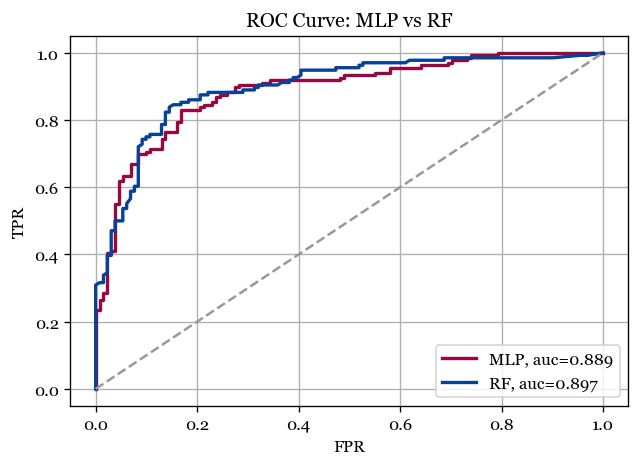

In [268]:
plt.figure(dpi=120, figsize=(6,4))
plt.plot(mlpfpr,mlptpr,label=f'MLP, auc={mlpauc:.3f}',color='#970742', linewidth=2)
plt.plot(rffpr,rftpr,label=f'RF, auc={rfauc:.3f}',color='#074297',linewidth=2)
plt.plot([0,1],[0,1],linestyle='--',color='0.6')
plt.legend()
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve: MLP vs RF')
plt.show()

### MLP

In [382]:
mlp_test_recall = []
mlp_train_recall = []
mlp_test_acc = []
for i in range(500):
    _, test_pred, test_true, train_pred, train_true =  mlp_class(training_data,train_size=0.8,hidden_layer_sizes=(2,),activation='tanh',alpha=1.1,max_iter=500,
                  features=['i','g','g-i'],solver='lbfgs', max_fun=15000, stats=True)
    tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
    mlp_test_recall.append(tp/(tp+fn))
    mlp_test_acc.append((tp+tn)/(tp+fp+tn+fn))
    tn, fp, fn, tp = confusion_matrix(train_true,train_pred,labels=['galaxy','gc']).ravel()
    mlp_train_recall.append(tp/(tp+fn))

In [383]:
np.median(mlp_test_acc)

0.8277153558052435

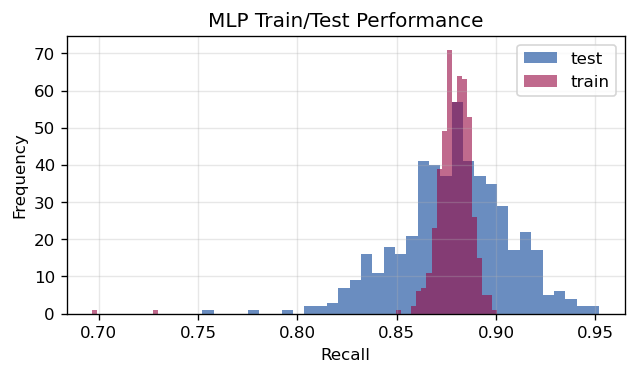

In [182]:
plt.figure(dpi=120, figsize=(6,3))
plt.hist(mlp_test_recall,bins=35,color='#074297',alpha=0.6,label='test')
plt.hist(mlp_train_recall,bins=80,color='#970742',alpha=0.6,label='train')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.title('MLP Train/Test Performance')
plt.show()

### Random Forest

In [203]:
n_trees = 40
max_depth_ = 5
max_leaf_nodes_ = None
min_samples_leaf_ = 2
min_samples_split_ = 0.01
max_features = 2

In [389]:
2*np.std(rf_test_recall)

0.06236198432343494

In [384]:
np.median(rf_test_acc)

0.8352059925093633

In [381]:
rf_test_recall = []
rf_train_recall = []
rf_test_acc = []
for i in range(500):
    _, test_pred, test_true, train_pred, train_true =  ranfor(training_data,stats=True,n_estimators=n_trees,max_depth=max_depth_, max_leaf_nodes=max_leaf_nodes_,
                                                              min_samples_leaf=min_samples_leaf_, features=features_, min_samples_split=min_samples_split_, max_features=2)
    tn, fp, fn, tp = confusion_matrix(test_true,test_pred,labels=['galaxy','gc']).ravel()
    rf_test_recall.append(tp/(tp+fn))
    rf_test_acc.append((tp+tn)/(tp+fp+tn+fn))
    tn, fp, fn, tp = confusion_matrix(train_true,train_pred,labels=['galaxy','gc']).ravel()
    rf_train_recall.append(tp/(tp+fn))
    

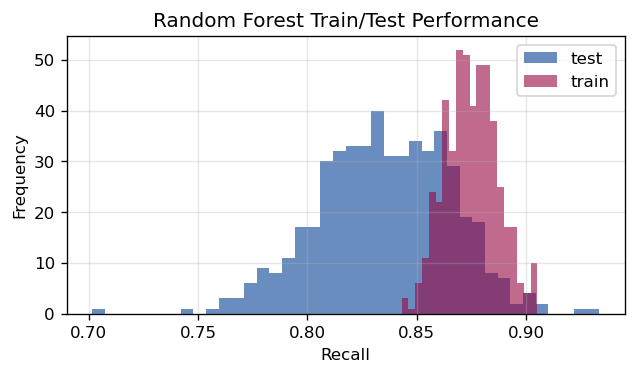

In [205]:
plt.figure(dpi=120, figsize=(6,3))
plt.hist(rf_test_recall,bins=40,color='#074297',alpha=0.6,label='test')
plt.hist(rf_train_recall,bins=20,color='#970742',alpha=0.6,label='train')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.title('Random Forest Train/Test Performance')
plt.show()

## Both models compared to each other

In [391]:
2*np.std(mlp_test_recall)

0.062052976219448115

In [380]:
np.median(mlp_test_recall)

0.88

In [379]:
np.median(rf_test_recall)

0.835820895522388

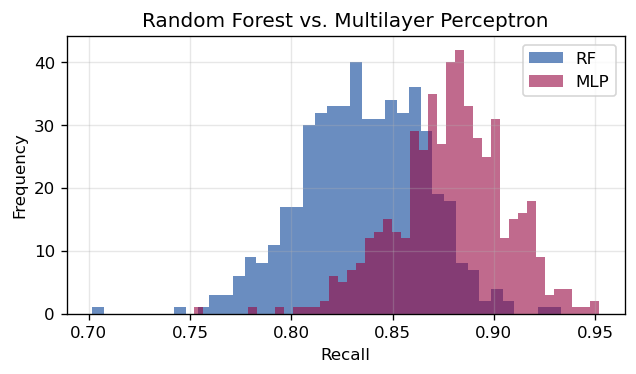

In [206]:
plt.figure(dpi=120, figsize=(6,3))
plt.hist(rf_test_recall,bins=40,color='#074297',alpha=0.6,label='RF')
plt.hist(mlp_test_recall,bins=45,color='#970742',alpha=0.6,label='MLP')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.title('Random Forest vs. Multilayer Perceptron')
plt.show()

# Generate region files from predictions
Takes a field and a date (for sorting into folders) and generates a region file for DS9 using the predictions for that field.

In [352]:
def make_reg_from_pred(field:int,date:str,filter_gc = True, app=''):
    predictions = pickle.load(open(f'pickle/predictions/{date}/predictionsf{field}{app}.pk','rb'))
    if filter_gc: gcs = predictions[predictions['pred']=='gc'] # only make regions for the gcs in the predictions
    else: gcs = predictions
    radius = '3"'
    Path(f'./ds9_regions/predictions/{date}').mkdir(parents=True, exist_ok=True)
    with open(f'./ds9_regions/predictions/{date}/{field}_predictions{app}.reg','w') as f:
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 14 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
        f.write('fk5 \n')
        for row in gcs:
            ra = str(row['RA'])
            dec = str(row['Dec'])
            f.write(f'circle({ra},{dec},{radius}) \n')

### Make the region file for field 229:

In [353]:
make_reg_from_pred(229, date='xxxx')

# Add points back into the training set
A set of functions to add points from region files back into the training set along with their i and g values, so the model can be retrained with more non-gc objects in.

In [149]:
# reads a region file and returns a list of coordinates for every point listed within
# note: the path parameter must be the path starting in the root directory (e.g. path='ds9_regions/folder/region.reg')
#      otherwise, the field parameter will look for the file 'ds9_regions/predictions/FIELD_predictions.reg'
# note: region file must be formatted with the first two lines defining the settings and coordinate system,
#       with the third line beginning the list of circle(x,y) or point(x,y)
def read_reg(field: int, path=None) -> list:
    if path is None:
        path = f'ds9_regions/predictions/{field}_predictions.reg'
    try:
        with open(path,'r') as f:
            reg_file_lines = f.readlines()[2:] # skip the first two lines
    except FileNotFoundError:
        print("Please enter a full path to the file from the current directory, or choose a field that has a predictions region file.")
        return 0
    
    ret = []
    for i in range(len(reg_file_lines)):
        coords = reg_file_lines[i].split('(')[1].split(',')[0:2] # split at the first open bracket, split along, commas, choose the first two values (the coordinates)
        ra = float(coords[0])
        dec = float(coords[1])
        ret.append((ra,dec))
    return ret

# takes a list of coordinates and field, and returns a list of values to add to training data
def get_data_from_coords(field: int, coords: list) -> list:
    cat = load_cat(field)[field]
    ret = []
    for c in coords:
        row = cat[(cat['RA']==c[0]) & (cat['Dec']==c[1])][0]
        i, g = row['i'], row['g']
        di, dg = row['di'], row['dg']
        g_i = g-i
        ra, dec = c
        # pdidx = # need to find a way of extracting the pandas index
        vals = (i,g,di,dg,ra,dec,field,g_i) # values for relevant columns in training
        ret.append(vals)
    return ret

# takes the training dataset and a list of values to add to it and returns a new dataframe with the added values
def add_nongc_to_training(train_df: pd.DataFrame, vals: list, nongc_class='galaxy') -> pd.DataFrame:
    # make dataframe from values
    columns = ['i','g','di','dg','ra','dec','field','g-i']
    add_df = pd.DataFrame(vals,columns=columns)
    add_df['obj_id'] = 'none'
    add_df['class'] = nongc_class
    add_df['pdidx'] = 0
    add_df['rbcidx'] = 0
    add_df['nearby'] = 0
    
    new_df = pd.concat([train_df, add_df],ignore_index=True, verify_integrity=True,copy=False)
    return new_df

def update_training_data(field:int, path=None, train_df=training_data, nongc_class='galaxy') -> pd.DataFrame:
    coords = read_reg(field, path=path)
    vals = get_data_from_coords(field,coords)
    new_training_data = add_nongc_to_training(train_df,vals,nongc_class=nongc_class)
    return new_training_data

# Find clusters of predictions
From region files, use DBSCAN to find clusters of predictions which signify relevant objects; a globular will often show up as a tight bunch of points where the ML model has picked up individual stars within. The following code clusters the predictions and saves region file for use in SAOImage DS9

In [354]:
from sklearn.cluster import DBSCAN
from pathlib import Path

date = 'xxxx'
# set dbscan parameters
eps = 0.003
min_samples = 4
leaf_size = 30
n_jobs = 1

#exclude fields directly around m31
#field_exclusions = [228, 232, 233, 235, 248, 249, 254, 257, 265, 266, 276, 279, 285, 288]
#fields = [i for i in range(1,407) if i not in field_exclusions]

fields = [229]

clusters_all = {}

for field in fields:
    # read in region file
    points = read_reg(field, path=f'./ds9_regions/predictions/{date}/{field}_predictions.reg')
    
    # apply dbscan to the set of points
    clustering = DBSCAN(eps=eps,min_samples=min_samples, metric='euclidean',
            metric_params=None, algorithm='auto', leaf_size=leaf_size, p=None, n_jobs=n_jobs).fit(points)

    # seperate points into their individual clusters
    cluster_labels = clustering.labels_
    clusters_all[field] = {} # initialise a dictionary of clusters 
    
    for i in range(len(points)):
        lbl = cluster_labels[i]
        if lbl == -1: continue # skip the non clustered points
        if lbl in clusters_all[field]:
            clusters_all[field][lbl].append(points[i])
        else:
            clusters_all[field][lbl] = [points[i]]
    
    coords = [[[clusters_all[field][lbl][i][a] for i in range(len(clusters_all[field][lbl]))] for lbl in clusters_all[field]] for a in [0,1]]
    ra = []
    dec = []
    for l in coords[0]:
        ra += l
    for l in coords[1]:
        dec += l

    Path(f'./pickle/predictions/{date}').mkdir(parents=True, exist_ok=True)

    coord_table = QTable((ra,dec),names=['RA','Dec'])
    with open(f'./pickle/predictions/{date}/predictionsf{field}_clusters.pk','wb') as f:
        pickle.dump(coord_table, f)

In [355]:
# turn each cluster into a single point for making region files with
cluster_centres = {}
for field in clusters_all:
    cluster_centres[field] = []
    field_clusters = clusters_all[field]
    for cluster_id in field_clusters:
        # take the mean position of the clusters
        clst_cen = tuple(np.mean(np.array(field_clusters[cluster_id]),axis=0))
        cluster_centres[field].append(clst_cen)

In [356]:
# write the clusters to region files
for field in cluster_centres:
    clusters = cluster_centres[field]
    radius = '16"'
    Path(f'./ds9_regions/predictions/{date}').mkdir(parents=True, exist_ok=True)
    with open(f'./ds9_regions/predictions/{date}/{field}_predictions_clusters.reg','w') as f:
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 14 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
        f.write('fk5 \n')
        for c in clusters:
            ra = str(c[0])
            dec = str(c[1])
            f.write(f'circle({ra},{dec},{radius}) \n')

In [326]:
cluster_centres

{229: [(7.409469791666665, 40.45806319444445),
  (7.087278472222221, 40.503308796296295),
  (7.146282291666665, 40.52723125),
  (6.743805208333332, 40.616056944444445),
  (6.747883333333333, 40.605018055555554),
  (6.608144791666666, 40.506193749999994),
  (6.412726041666667, 40.47321597222223),
  (7.399202976190476, 40.3707746031746),
  (7.436926041666665, 40.342536805555554),
  (7.346875, 40.26486111111112),
  (6.864573958333334, 40.28639097222222),
  (6.710561805555556, 40.250455092592595),
  (6.7261156249999985, 40.19017430555555),
  (6.685579861111111, 40.2908412037037),
  (6.492726041666667, 40.306083333333326),
  (6.2705625000000005, 40.26532986111111),
  (7.097441666666666, 40.03891180555555),
  (7.178823958333333, 40.17557708333334),
  (7.013404761904761, 40.04897499999999),
  (6.819382500000001, 40.01939611111111),
  (6.666372916666666, 40.0134625),
  (6.741590624999999, 40.175853472222215),
  (6.621580833333333, 40.000297222222216),
  (6.413700757575756, 39.95037323232323),


In [162]:
def match_master_to_cluster(cluster_list: list):
    d1 = master_cat
    ra_obs, dec_obs = d1['RADEG'], d1['DECDEG']
    d2 = cluster_list
    ra_qry, dec_qry = [c[0] for c in d2], [c[1] for c in d2]
    
    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, d2d, _ = c1.match_to_catalog_sky(c2)
    return idx,d2d

In [163]:
match_master_to_cluster(cluster_centres[229])

(array([41,  3, 15, ..., 15,  6, 15], dtype=int64),
 <Angle [ 8.78936634, 11.79948304,  4.06197149, ...,  6.84237188,
          6.113014  ,  5.33925976] deg>)

In [55]:
#fields = [135,148,163,178,208,207,229,222,273,274]

field = 207
clusters = clusters_all[field]
cat = load_cat(field)
clusters_rows = {}
for c in clusters:
    cluster_matches = match_objs(field, clusters[c])
    clusters_rows[c] = cat[cluster_matches]

In [58]:
clusters_rows

{0: <Table length=18>
    RA       Dec     iccd    xg      yg   ...    i       di    ii   ia  field 
 float32   float32  uint8 float32 float32 ... float32 float32 int8 int8 uint16
 -------- --------- ----- ------- ------- ... ------- ------- ---- ---- ------
 8.712679 39.545162     3  1577.8 3011.89 ...  19.783   0.003    1    0    207
 8.718629 39.544273     3 1666.73 3028.55 ...  20.404   0.005    1    0    207
 8.718521 39.542015     3 1665.11 3072.55 ...  20.744   0.007    1    0    207
 8.715775  39.54709     3 1624.08 2974.22 ...  20.942   0.008    1    0    207
 8.714812 39.545647     3 1609.71 3002.33 ...   21.24    0.01    1    0    207
 8.709954 39.544704     3 1537.12 3021.16 ...  21.485   0.012    1    0    207
 8.713062 39.541767     3 1583.52 3077.91 ...  22.429   0.026    1    0    207
 8.703762  39.54412     3  1444.6  3033.3 ...  22.561   0.029    1    0    207
 8.715287  39.54267     3 1616.76 3060.03 ...  22.682   0.032    1    0    207
 8.705625  39.54378     3  147

Text(0, 0.5, 'g-i')

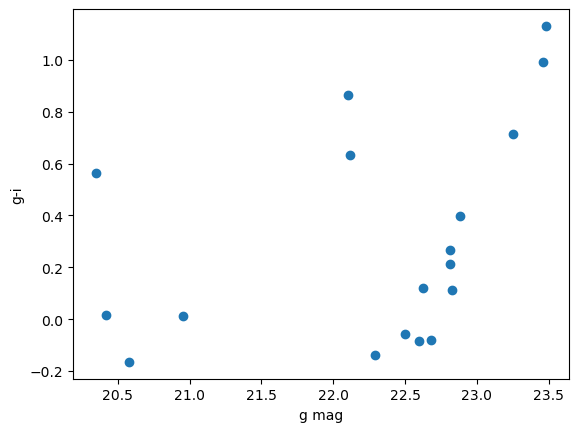

In [57]:
c=0
plt.scatter(clusters_rows[c]['g'],clusters_rows[c]['g']-clusters_rows[c]['i'])
plt.xlabel('g mag')
plt.ylabel('g-i')

### load in training data to plot colour-magnitude of training objects

In [81]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'

train_file = 'training_data_2702_j.pk'

with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [118]:
objs = training_data[training_data['class']=='gc']
objs_gal = training_data[training_data['class']=='galaxy']

In [114]:
clusters_rows

{0: <Table length=18>
    RA       Dec     iccd    xg      yg   ...    i       di    ii   ia  field 
 float32   float32  uint8 float32 float32 ... float32 float32 int8 int8 uint16
 -------- --------- ----- ------- ------- ... ------- ------- ---- ---- ------
 8.712679 39.545162     3  1577.8 3011.89 ...  19.783   0.003    1    0    207
 8.718629 39.544273     3 1666.73 3028.55 ...  20.404   0.005    1    0    207
 8.718521 39.542015     3 1665.11 3072.55 ...  20.744   0.007    1    0    207
 8.715775  39.54709     3 1624.08 2974.22 ...  20.942   0.008    1    0    207
 8.714812 39.545647     3 1609.71 3002.33 ...   21.24    0.01    1    0    207
 8.709954 39.544704     3 1537.12 3021.16 ...  21.485   0.012    1    0    207
 8.713062 39.541767     3 1583.52 3077.91 ...  22.429   0.026    1    0    207
 8.703762  39.54412     3  1444.6  3033.3 ...  22.561   0.029    1    0    207
 8.715287  39.54267     3 1616.76 3060.03 ...  22.682   0.032    1    0    207
 8.705625  39.54378     3  147

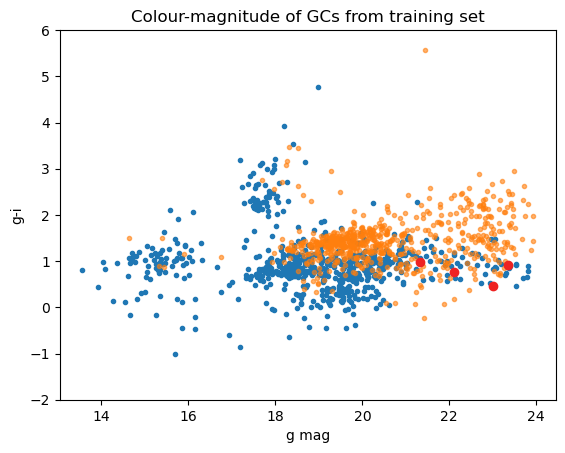

In [127]:
plt.scatter(objs['g'],-objs['g-i'],marker='.')#,c=objs['i'])
plt.scatter(objs_gal['g'],-objs_gal['g-i'],marker='.',alpha=0.6)#,c=objs['i'])
c=21
plt.scatter(clusters_rows[c]['g'],clusters_rows[c]['g']-clusters_rows[c]['i'], c='#E22')
plt.xlabel('g mag')
plt.ylabel('g-i')
plt.title('Colour-magnitude of GCs from training set')
plt.ylim([-2,6])
#plt.colorbar()
plt.show()

In [110]:
clusters_rows[0]

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,ia,field
float32,float32,uint8,float32,float32,float32,float32,int8,float32,float32,float32,float32,int8,int8,uint16
8.712679,39.545162,3,1577.8,3011.89,20.345,0.003,1,1565.62,3040.74,19.783,0.003,1,0,207
8.718629,39.544273,3,1666.73,3028.55,20.419,0.003,1,1654.53,3057.34,20.404,0.005,1,0,207
8.718521,39.542015,3,1665.11,3072.55,20.579,0.003,1,1652.92,3101.34,20.744,0.007,1,0,207
8.715775,39.54709,3,1624.08,2974.22,20.954,0.004,1,1611.88,3003.05,20.942,0.008,1,0,207
8.714812,39.545647,3,1609.71,3002.33,22.105,0.008,1,1597.52,3031.16,21.24,0.01,1,0,207
8.709954,39.544704,3,1537.12,3021.16,22.118,0.008,1,1524.94,3049.96,21.485,0.012,1,0,207
8.713062,39.541767,3,1583.52,3077.91,22.29,0.009,1,1571.35,3106.72,22.429,0.026,1,0,207
8.703762,39.54412,3,1444.6,3033.3,22.502,0.011,1,1432.45,3062.03,22.561,0.029,1,0,207
8.715287,39.54267,3,1616.76,3060.03,22.598,0.012,1,1604.58,3088.81,22.682,0.032,1,0,207
